# Demosaicking

The goal of this exercise is to simulate demosaicking algorithm, which converts raw data read from CMOS sensor into digital RGB image. 

In most modern cameras CFA, which stands for *color filter array* is build in such a way, that a single pixel only registers one color, which create so called *mosaicking*. The colors are arranged in a pattern, which is usually specific for given camera (two examples are provided in the exercise). Then full color image is constructed using *demosaicking* algorithms, which could be implemented by using image interpolation for example.

### Sources
* [https://en.wikipedia.org/wiki/Demosaicing](https://en.wikipedia.org/wiki/Demosaicing)
* [https://en.wikipedia.org/wiki/Bayer](https://en.wikipedia.org/wiki/Bayer)
* [http://nagykrisztian.com/store/hirakawa.pdf](http://nagykrisztian.com/store/hirakawa.pdf)
* [https://ui.adsabs.harvard.edu/abs/2006JEI....15a3003C/abstract](https://ui.adsabs.harvard.edu/abs/2006JEI....15a3003C/abstract)
* [https://paperswithcode.com/task/demosaicking](https://paperswithcode.com/task/demosaicking)
* [https://www.semanticscholar.org/paper/Color-filter-array-recovery-using-a-threshold-based-Chang-Cheung/361502aad08b474fa7a399532608f855651a9cc4](https://www.semanticscholar.org/paper/Color-filter-array-recovery-using-a-threshold-based-Chang-Cheung/361502aad08b474fa7a399532608f855651a9cc4)

In [1]:
import numpy as np
from scipy import ndimage
from skimage import io
from skimage import transform

In [2]:
image = io.imread(r"data/image.jpg")
image = image[:,:,:3]  # ignore last dimension if RGBA image is used
image = transform.resize(image, output_shape=(1024, 1024, 3))  # make image shape divisible by maks size 
image.shape

(1024, 1024, 3)

In [3]:
def color_filter_array(mask, shape):
    """Simulate CFA for given mask and image size"""
    return np.dstack(
        [
            np.tile(mask[:, :, channel], np.asarray(shape) // len(mask[:, :, channel]))
            for channel in range(mask.shape[-1])
        ]
    )

# Bayer Mask

Bayer mask is common mosaicking pattern with 2x2 pixel shape.

In [4]:
bayer_mask = np.array([[[0, 1], [0, 0]],                   # R
                       [[1, 0], [0, 1]],                   # G
                       [[0, 0], [1, 0]]], dtype=np.uint8)  # B

bayer_mask.shape  # channel x pixel x pixel

(3, 2, 2)

This is where "real" image is converted to "simulated" sensor reading with Bayer filter

In [5]:
bayer_filter = color_filter_array(bayer_mask, shape=np.array([1024, 1024]))

Show slices of Bayer mask for each color channel

In [6]:
bayer_filter[:4, :4, 0]  # red mask for bayer filter

array([[0, 1, 0, 1],
       [0, 0, 0, 0],
       [0, 1, 0, 1],
       [0, 0, 0, 0]], dtype=uint8)

In [7]:
bayer_filter[:4, :4, 1]  # green mask for bayer filter

array([[1, 0, 1, 0],
       [0, 1, 0, 1],
       [1, 0, 1, 0],
       [0, 1, 0, 1]], dtype=uint8)

In [8]:
bayer_filter[:4, :4, 2]  # blue mask for bayer filter

array([[0, 0, 0, 0],
       [1, 0, 1, 0],
       [0, 0, 0, 0],
       [1, 0, 1, 0]], dtype=uint8)

Filter needs to be create in the same shape as mask

In [9]:
image.shape, bayer_filter.shape

((1024, 1024, 3), (1024, 1024, 3))

Convert image to "simulated" sensor reading by element-wise multiplication

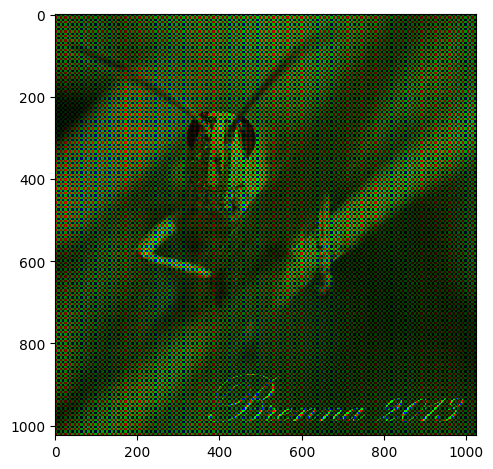

In [10]:
sensor_image = image * bayer_filter
_ = io.imshow(sensor_image)

Create demosaicking convolution mask by simply using mean interpolation taking into account the number of pixels in each color of the mask. Each color needs to gain its missing pixels, so the amount of gain is equal to: $ N / M $, where $N$ is the mask size and $M$ is the amount of pixels of given color. For Bayer mask red and blue pixels need to have a gain of 4 and green needs a gain of 2. To implement gain in mean convolution kernel, the sum of constant components needs to be equal to it, so in 2x2 kernel gain of 4 is just ones and gain of 2 is mask full of 0.5. 

In [11]:
demosaicking_convolution_mask = np.dstack([
    np.ones([2, 2]),        # R
    0.5 * np.ones([2, 2]),  # G
    np.ones([2, 2]),        # B
])

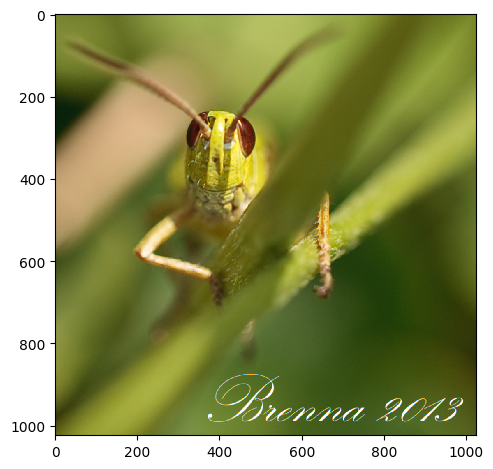

In [12]:
reconstructed_image = np.dstack([
    # mode needs to be constant or demosaicking mask will "catch" more than single nonzero pixel along the edges
    ndimage.convolve(sensor_image[:, :, channel], demosaicking_convolution_mask[:, :, channel], mode="constant", cval=0.0)
    for channel in range(3)
])

_ = io.imshow(reconstructed_image)